## Visualizing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("chess_dataset.csv")
df.head()

,ranked,winner,white_rating,black_rating,strategy_code,strategy_name,setup_turns
0,False,white,1500,1191,D10,Slav Defense: Exchange Variation,5
1,True,black,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4
2,True,white,1496,1500,C20,King's Pawn Game: Leonardis Variation,3
3,True,white,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,3
4,True,white,1523,1469,C41,Philidor Defense,5


In [3]:
df.tail()

,ranked,winner,white_rating,black_rating,strategy_code,strategy_name,setup_turns
20053,True,white,1691,1220,A80,Dutch Defense,2
20054,True,black,1233,1196,A41,Queen's Pawn,2
20055,True,white,1219,1286,D00,Queen's Pawn Game: Mason Attack,3
20056,True,white,1360,1227,B07,Pirc Defense,4
20057,True,black,1235,1339,D00,Queen's Pawn Game: Mason Attack,3


Persebaran pemenang dan jumlah permainan ranked

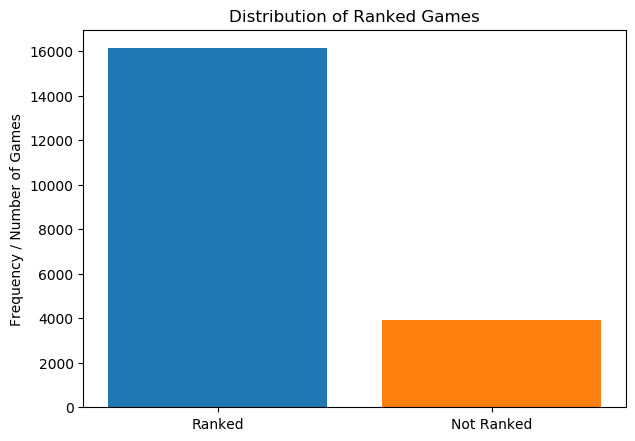

In [4]:
fig = plt.figure(figsize=[7,5], dpi = 100)

ranked = nranked = 0

for row in df.index:
    if (df['ranked'].iloc[row] == True):
        ranked = ranked + 1
    else:
        nranked = nranked + 1

labels = ['Ranked', 'Not Ranked']
x = np.arange(len(labels))

plt.bar(0, ranked)
plt.bar(1, nranked)
plt.xticks(x, labels)

plt.title("Distribution of Ranked Games")
plt.ylabel("Frequency / Number of Games")
plt.show()

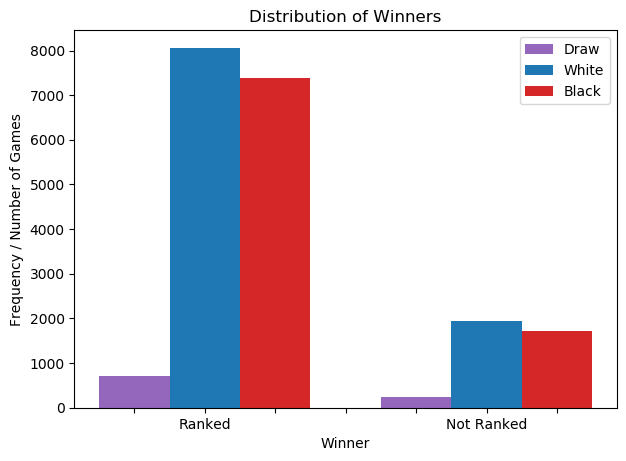

In [5]:
fig = plt.figure(figsize=[7,5], dpi=100)

draw = white = black = 0

for row in df.index:
    if (df['ranked'].iloc[row] == True):
        if (df['winner'].iloc[row] == 'draw'):
            draw = draw + 1
        elif (df['winner'].iloc[row] == 'white'):
            white = white + 1
        else:
            black = black + 1        
            
plt.bar(0, draw, width=1, color='tab:purple')
plt.bar(1, white, width=1, color='tab:blue')
plt.bar(2, black, width=1, color='tab:red')

draw = white = black = 0

for row in df.index:
    if (df['ranked'].iloc[row] == False):
        if (df['winner'].iloc[row] == 'draw'):
            draw = draw + 1
        elif (df['winner'].iloc[row] == 'white'):
            white = white + 1
        else:
            black = black + 1

plt.bar(4, draw, width=1, color='tab:purple')
plt.bar(5, white, width=1, color='tab:blue')
plt.bar(6, black, width=1, color='tab:red')

label=['', 'Ranked', '', '', '', 'Not Ranked', '']
x = np.arange(len(label))
plt.xticks(x, label)

plt.xlabel("Winner")
plt.legend(['Draw', 'White', 'Black'])
plt.ylabel("Frequency / Number of Games")
plt.title('Distribution of Winners')

plt.show()

Persebaran rating untuk kedua sisi

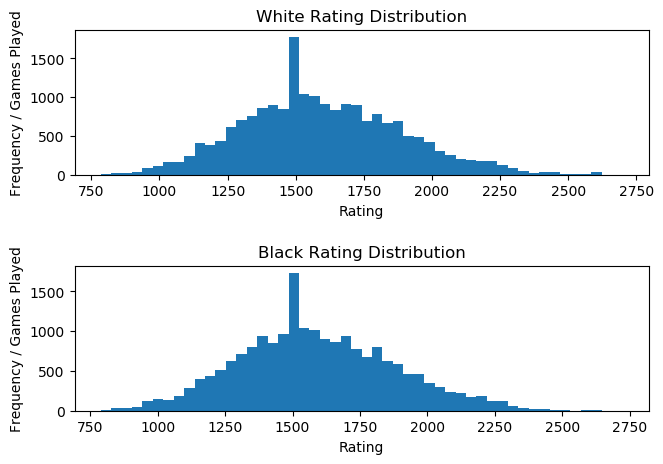

In [6]:
fig = plt.figure(figsize=[7,5], dpi=100)

gs = fig.add_gridspec(2, 1)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.hist(df['white_rating'], bins = 50)

ax2.hist(df['black_rating'], bins = 50)

ax1.set_ylabel("Frequency / Games Played")
ax2.set_ylabel("Frequency / Games Played")
ax1.set_xlabel("Rating")
ax2.set_xlabel("Rating")
ax1.set_title("White Rating Distribution")
ax2.set_title("Black Rating Distribution")

fig.tight_layout(pad=2)
plt.show(fig)

Menghitung mean dan modus untuk kedua sisi

In [7]:
print(df['white_rating'].mode())
print('\nMean: ', df['white_rating'].mean())

0    1500
dtype: int64

Mean:  1596.6318675840064


In [8]:
print(df['black_rating'].mode())
print('\nMean: ', df['black_rating'].mean())

0    1500
dtype: int64

Mean:  1588.8319872370128


## Grouping Data

In [9]:
strat_name = df.strategy_name.map(
                lambda n: n.split(":")[0].split("|")[0].split("#")[0].strip()
            )

df = df.assign(strategy_type=strat_name)
df.head()

,ranked,winner,white_rating,black_rating,strategy_code,strategy_name,setup_turns,strategy_type
0,False,white,1500,1191,D10,Slav Defense: Exchange Variation,5,Slav Defense
1,True,black,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,Nimzowitsch Defense
2,True,white,1496,1500,C20,King's Pawn Game: Leonardis Variation,3,King's Pawn Game
3,True,white,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,3,Queen's Pawn Game
4,True,white,1523,1469,C41,Philidor Defense,5,Philidor Defense


In [10]:
opening_used = (pd.concat([
                   df.groupby('white_rating')['strategy_type'].value_counts(),
                   df.groupby('black_rating')['strategy_type'].value_counts()
                ])
                    .rename(index='openings_used')
                    .reset_index()
                    .rename(columns={'white_rating': 'rating', 'openings_used': 'times_used'})
                    .groupby(['rating', 'strategy_type']).sum()
               )

opening_used.head() # tabel penggunaan strategi per rating

times_used
rating strategy_type                     
784    King's Knight Opening            1
       King's Pawn Game                 1
788    Zukertort Opening                1
789    Sicilian Defense                 1
791    Blackmar-Diemer Gambit           1

## Utility Matrix dan Rating

In [11]:
def threshold_map(n_opening, n_all):
    if pd.isnull(n_opening):
        return np.nan
    elif n_opening  / n_all >= 1 / 4:
        return 5
    elif n_opening  / n_all >= 1 / 8:
        return 4
    elif n_opening  / n_all >= 1 / 16:
        return 3
    else:
        return 2

matrix = opening_used.unstack(-1).loc[:, 'times_used'].apply(
    lambda srs: srs.map(lambda v: threshold_map(v, srs.sum())),
    axis='columns'
)

In [12]:
matrix.head(10)

strategy_type,Alekhine Defense,Amar Opening,Amazon Attack,Anderssen Opening,Australian Defense,Barnes Defense,Barnes Opening,Benko Gambit,Benko Gambit Accepted,Benko Gambit Declined,...,Trompowsky Attack,Valencia Opening,Van Geet Opening,Van't Kruijs Opening,Vienna Game,Wade Defense,Ware Defense,Ware Opening,Yusupov-Rubinstein System,Zukertort Opening
rating,,,,,,,,,,,,,,,,,,,,,
784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Menghitung sparsitas dari Data

In [13]:
matrix_size = matrix.shape[0]*matrix.shape[1] # 1622 x 143 - besar matrix
not_null = len(opening_used['times_used']) # Jumlah kotak yang tidak kosong
sparsity = 100*(1 - (not_null/matrix_size))

sparsity # Persentase kekosongan matrix

90.30334646857459

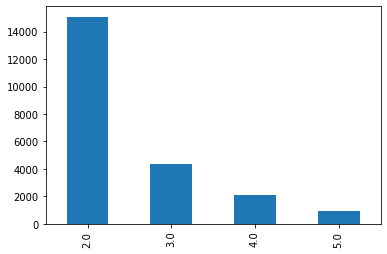

In [14]:
pd.Series(matrix.values.flatten()).value_counts().sort_index().plot.bar()
plt.show()

### Item Based CF

In [15]:
from sklearn.metrics.pairwise import pairwise_distances

# user_similarity = pairwise_distances(train.fillna(0), metric='cosine')

item_similarity = pairwise_distances(matrix.T.fillna(0), metric='cosine')

correction = np.array([np.abs(item_similarity).sum(axis=1)])
item_predictions = matrix.fillna(0).dot(item_similarity).apply(
    lambda srs: srs / np.array([item_similarity.sum(axis=1)]).flatten(), axis='columns')

item_predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
rating,,,,,,,,,,,,,,,,,,,,,
784,0.055851,0.067868,0.067326,0.066195,0.068968,0.065285,0.068894,0.071442,0.071130,0.070553,...,0.068524,0.069621,0.062375,0.048817,0.059485,0.071556,0.066697,0.068137,0.068329,5.789981e-02
788,0.029735,0.034382,0.035862,0.034133,0.033836,0.033132,0.035110,0.034903,0.034478,0.035165,...,0.033730,0.034806,0.032294,0.030368,0.030782,0.034425,0.034319,0.032555,0.033650,1.319599e-16
789,0.025917,0.033653,0.034103,0.031778,0.034015,0.032958,0.034016,0.033914,0.033445,0.033733,...,0.030421,0.034951,0.031076,0.024673,0.026911,0.033735,0.033050,0.032797,0.031241,2.232719e-02
791,0.036425,0.035677,0.034335,0.034099,0.033435,0.034662,0.035787,0.035947,0.035699,0.035496,...,0.035536,0.035551,0.035995,0.035128,0.033168,0.034142,0.036031,0.034262,0.034255,3.531439e-02
793,0.026003,0.033065,0.032970,0.032801,0.034419,0.033719,0.033906,0.034789,0.034539,0.034577,...,0.031108,0.035137,0.030017,0.023742,0.028070,0.033710,0.032956,0.033030,0.032353,2.330825e-02


In [16]:
opening_names = pd.Series(matrix.columns)

recommended_opening_numbers = item_predictions.apply(
    lambda srs: np.argmax(srs.values), axis='columns'
)

recommended_openings = recommended_opening_numbers.map(opening_names)

recommended_openings.head(10)

rating
784         Neo-Gruenfeld Defense
788    Queen's Indian Accelerated
789          Center Game Accepted
791                  Reti Opening
793               Lemming Defense
795                  Carr Defense
796          Center Game Accepted
798    Queen's Indian Accelerated
800                  Wade Defense
801                  Wade Defense
dtype: object

In [17]:
recommended_openings.tail(10)

rating
2579      King's Pawn Game
2586      King's Pawn Game
2588    Rubinstein Opening
2613    Rubinstein Opening
2617          Giuoco Piano
2619    Rubinstein Opening
2621    Rubinstein Opening
2622       Lemming Defense
2700       Lemming Defense
2723      Sicilian Defense
dtype: object

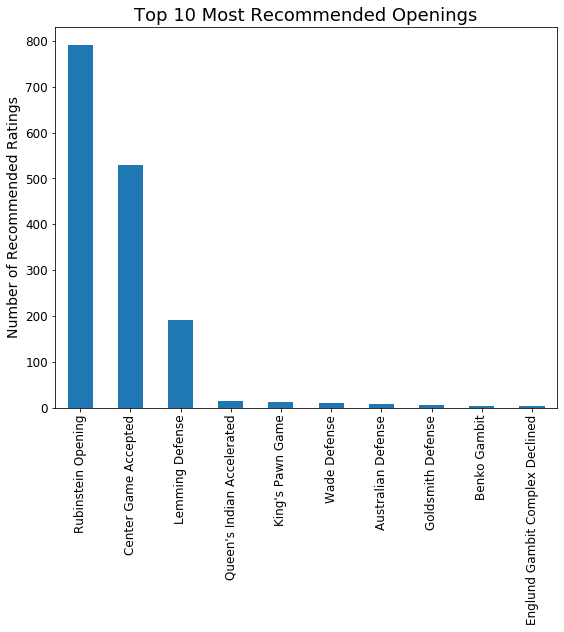

Rubinstein Opening            791
Center Game Accepted          530
Lemming Defense               191
Queen's Indian Accelerated     14
King's Pawn Game               13
dtype: int64

In [18]:
recommended_openings.value_counts().head(10).iloc[0:].plot.bar(figsize=(9, 7), fontsize=12)
plt.ylabel('Number of Recommended Ratings', fontsize=14)
plt.title('Top 10 Most Recommended Openings', fontsize=18)
plt.show()
recommended_openings.value_counts().head()

## Testing for Better Results

In [19]:
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from implicit.als import AlternatingLeastSquares

In [20]:
data = (pd.concat([
                   df.groupby('white_rating')['strategy_type'].value_counts(),
                   df.groupby('black_rating')['strategy_type'].value_counts()
                ])
                    .rename(index='openings_used')
                    .reset_index()
                    .rename(columns={'white_rating': 'rating', 'openings_used': 'times_used'})
               )

In [21]:
data['strategy_id'] = data['strategy_type'].astype('category').cat.codes
data['user_id'] = data['rating'].astype("category").cat.codes

data.head() # Mengubah rating dan strategi menjadi id

,rating,strategy_type,times_used,strategy_id,user_id
0,784,King's Knight Opening,1,70,0
1,784,King's Pawn Game,1,72,0
2,788,Zukertort Opening,1,142,1
3,793,Queen's Pawn Game,1,109,4
4,795,French Defense,1,47,5


In [31]:
item_lookup = data[['strategy_id', 'strategy_type']].drop_duplicates() # Membuat tabel untuk mencocokkan id
item_lookup['strategy_id'] = item_lookup.strategy_id.astype(str)

item_user = sp.csr_matrix((data['times_used'].astype(float), (data['strategy_id'], data['user_id'])))
user_item = sp.csr_matrix((data['times_used'].astype(float), (data['user_id'], data['strategy_id'])))

In [32]:
model = AlternatingLeastSquares(factors=20, regularization = 0.1, iterations = 50)

alpha = 15
model.fit(item_user*alpha)

user_vecs = model.user_factors
item_vecs = model.item_factors

100%|████████████████████████████████████████████████████████████████████████████████| 50.0/50 [00:01<00:00, 27.17it/s]


In [33]:
user_vecs[1621]

array([ 0.40165505,  0.45117468, -0.2700052 ,  0.04725379, -0.32960328,
        0.63816404,  0.36971936,  0.14817141, -0.06274742,  0.42832845,
        0.44046456, -0.5416433 ,  0.04696117,  0.26068863, -0.34001708,
        0.3466685 ,  0.2575936 ,  0.1540806 ,  0.02451641, -0.24731524],
      dtype=float32)

In [34]:
item_vecs[142]

array([-0.02904611,  0.09294707, -0.1462949 ,  0.20951964, -0.11141801,
       -0.02307488,  0.10874715, -0.03413364,  0.216075  , -0.16774951,
       -0.32904673,  0.00092444,  0.1291828 , -0.02307776, -0.00309197,
       -0.27574953,  0.06113844, -0.04921557,  0.21291499,  0.06072351],
      dtype=float32)

In [35]:
item_id = 70 # King's Knight Opening
n_similar = 10

# Use implicit to get similar items.
similar = model.similar_items(item_id, n_similar)

# Print the names of our most similar artists
for item in similar:
    idx, score = item
    print (data.strategy_type.loc[data.strategy_id == idx].iloc[0])

King's Knight Opening
Four Knights Game
Indian Game
Doery Defense
Guatemala Defense
Barnes Defense
Irish Gambit
Sodium Attack
Alekhine Defense
Center Game


In [36]:
user_id = 0 # Rating 784

recommended = model.recommend(user_id, user_item)

strategies = []
scores = []

# Get strategy names from ids
for item in recommended:
    idx, score = item
    strategies.append(data.strategy_type.loc[data.strategy_id == idx].iloc[0])
    scores.append(score)

# Create a dataframe of strategies and scores
recommendations = pd.DataFrame({'Strategy': strategies, 'score': scores})

print (recommendations)

               Strategy     score
0     Four Knights Game  0.904709
1      Sicilian Defense  0.573528
2        French Defense  0.564570
3     Queen's Pawn Game  0.563432
4  Scandinavian Defense  0.540449
5             Ruy Lopez  0.532902
6          Italian Game  0.524002
7      Philidor Defense  0.516388
8       English Opening  0.510184
9     Caro-Kann Defense  0.477343


In [37]:
strategies = []
scores = []

for user_id in range(0, 1622):

    recommended = model.recommend(user_id, user_item, 1)

    # Get strategy names from ids
    for item in recommended:
        idx, score = item
        strategies.append(data.strategy_type.loc[data.strategy_id == idx].iloc[0])
        scores.append(score)

# Create a dataframe of strategies and scores
recommendations = pd.DataFrame({'Strategy': strategies, 'score': scores}, index=data['rating'].unique())

recommendations.head()

,Strategy,score
784,Four Knights Game,0.904709
788,Nimzowitsch Defense,0.842777
793,French Defense,0.617986
795,Russian Game,0.480628
798,Sicilian Defense,0.645327


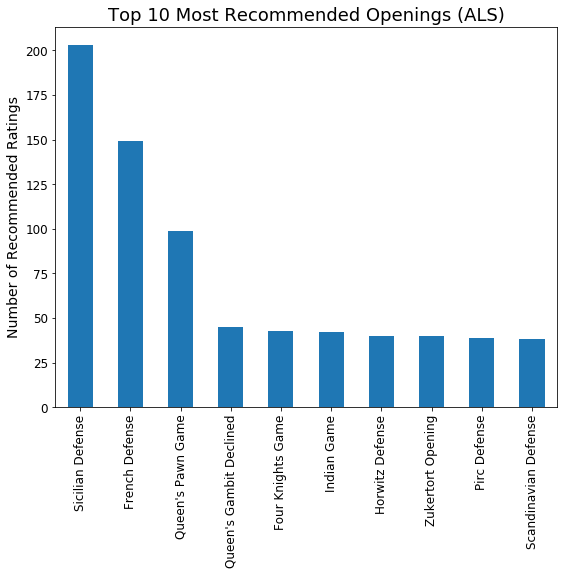

Sicilian Defense           203
French Defense             149
Queen's Pawn Game           99
Queen's Gambit Declined     45
Four Knights Game           43
Indian Game                 42
Horwitz Defense             40
Zukertort Opening           40
Pirc Defense                39
Scandinavian Defense        38
Name: Strategy, dtype: int64

In [38]:
recommendations['Strategy'].value_counts().head(10).iloc[0:].plot.bar(figsize=(9, 7), fontsize=12)
plt.ylabel('Number of Recommended Ratings', fontsize=14)
plt.title('Top 10 Most Recommended Openings (ALS)', fontsize=18)
plt.show()
recommendations['Strategy'].value_counts().head(10)